# Testing bias metrics and mitigation algorithms on a Synthetic dataset

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [1]:
# import libraries
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from Sampler import Sampler
from utility import *
sns.set_theme()

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [2]:
data = pd.read_csv('synthetic/synthetic.csv')
data

,0,1,2,3,4,5,6,7,8,9,10,s
0,1.117819,2.978286,0.446270,1.462078,-0.603682,-1.010214,-0.850477,-0.534090,2.619979,2.847635,1.0,0
1,-1.241114,0.966580,2.522553,2.197615,-2.049246,-2.272453,-0.912986,-1.074081,0.156897,-0.893949,0.0,0
2,1.499456,3.462662,-1.581721,-0.717028,0.706507,0.067985,1.081010,-1.360287,2.342430,2.600052,1.0,1
3,1.119152,-1.030551,2.154243,-1.041053,0.374413,-1.707872,1.508272,0.426323,-1.545117,-1.741156,0.0,0
4,0.951065,3.900728,0.127303,-0.075893,0.416828,-1.444766,-0.093549,-2.440322,2.097760,1.317815,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.254664,-0.585287,3.564289,-0.540535,-1.765657,0.333707,-1.830294,-1.157792,4.047647,0.873255,0.0,0
9996,-0.235269,1.753106,-1.981381,-0.916348,-0.086612,-2.525506,-0.388470,0.550074,-4.543743,-1.528656,1.0,1
9997,-0.110675,3.144627,-0.940214,0.213754,0.564466,-0.832604,0.367032,-1.312953,1.141139,1.463263,1.0,0
9998,-0.072732,3.316492,-1.425743,-0.717678,0.543238,0.899736,0.086791,-2.040534,3.629779,2.835108,1.0,0


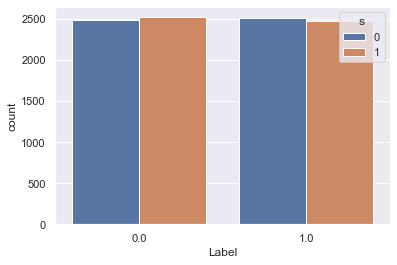

In [3]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [4]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Bias metrics

Here we train and test a _Logistic Regression_ classifier:

### Dataset Metrics:

Disparate Impact: 1.0162
Statistical Parity: 0.0080




### Classification Metrics:

Balanced accuracy: 0.7623
Statistical parity difference: 0.0188
Disparate impact: 1.0378
Average odds difference: 0.0148
Equal opportunity difference: 0.0210
Theil index: 0.1482


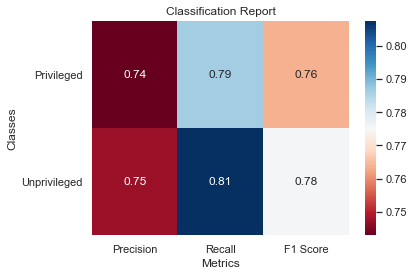

In [5]:
bin_data = BinaryLabelDataset(df=data, protected_attribute_names=['s'], label_names=['10'])

class_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    bin_data, privileged_group, unprivileged_group)

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [6]:
rw_unbias_data = bin_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
#rw_unbias_data = rw.fit_transform(rw_unbias_data)

In [7]:
#np.unique(rw_unbias_data.instance_weights)

In [8]:
#sns.violinplot(data=rw_unbias_data.instance_weights)
#plt.show()

### Dataset metrics

In [9]:
#metrics = compute_dataset_fairness_metrics(rw_unbias_data, unprivileged_group, privileged_group)

### Classification metrics

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7627
Statistical parity difference: 0.0102
Disparate impact: 1.0219
Average odds difference: 0.0055
Equal opportunity difference: 0.0086
Theil index: 0.1480


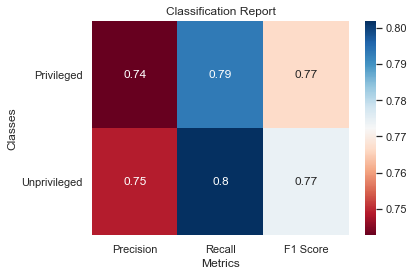

In [10]:
rw_un_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_unbias_data, privileged_group, unprivileged_group, debiaser=rw)

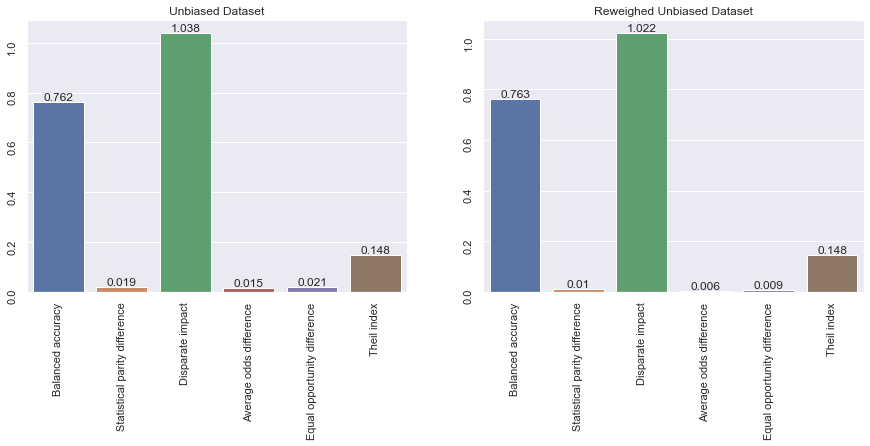

In [11]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [12]:
dir_unb_data = bin_data.copy()
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

In [13]:
#plot_correlation(dir_unb_data, 's')
#plt.show()

In [14]:
di = DisparateImpactRemover(sensitive_attribute='s')
#dir_unb_data = di.fit_transform(dir_unb_data)

### Dataset metrics

In [15]:
#metrics = compute_dataset_fairness_metrics(dir_unb_data, unprivileged_group, privileged_group)

### Classification metrics

### Dataset Metrics:

Disparate Impact: 1.0162
Statistical Parity: 0.0080




### Classification Metrics:

Balanced accuracy: 0.7654
Statistical parity difference: -0.0011
Disparate impact: 0.9996
Average odds difference: -0.0062
Equal opportunity difference: -0.0052
Theil index: 0.1362


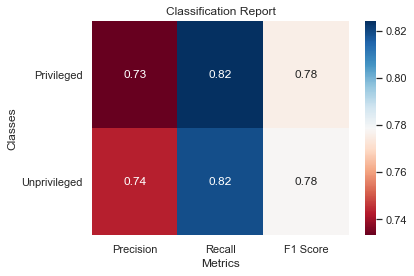

In [16]:
dir_fair_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_unb_data, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=di)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


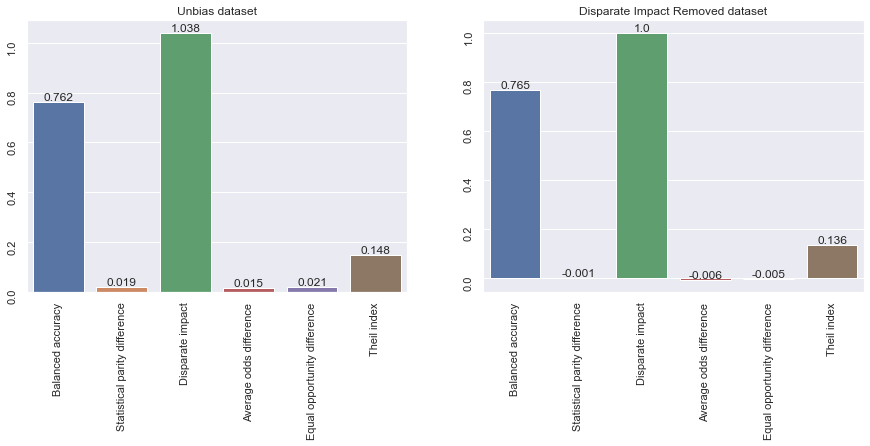

In [17]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Modified Reweighing (Sampling)

In [18]:
unb_sample_ds = bin_data.copy()
sampler = Sampler(round_level=3)

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 1.0008
Statistical Parity: 0.0004




### Classification Metrics:

Balanced accuracy: 0.7625
Statistical parity difference: 0.0096
Disparate impact: 1.0196
Average odds difference: 0.0058
Equal opportunity difference: 0.0096
Theil index: 0.1482


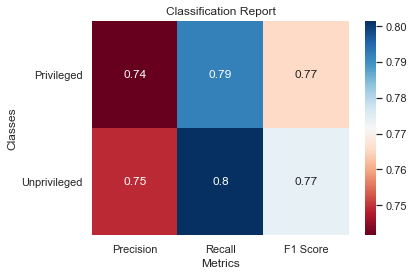

In [19]:
unb_sample_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  unb_sample_ds, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


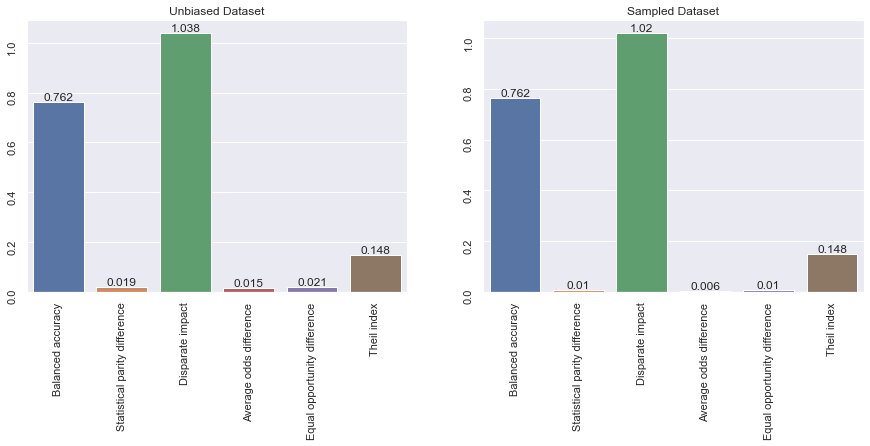

In [20]:
plot_metrics_comparison(class_metrics, unb_sample_metrics, 'Unbiased Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [21]:
un_merged_metrics = merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Sampled Dataset': unb_sample_metrics,
    'Disparate Impact Removed': dir_fair_metrics
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Disparate Impact Removed,-0.0062,0.7654,0.9996,-0.0052,-0.0011,0.1362
Reweighed,0.0055,0.7627,1.0219,0.0086,0.0102,0.1480
Sampled Dataset,0.0058,0.7625,1.0196,0.0096,0.0096,0.1482
Unbias Data,0.0148,0.7623,1.0378,0.0210,0.0188,0.1482


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


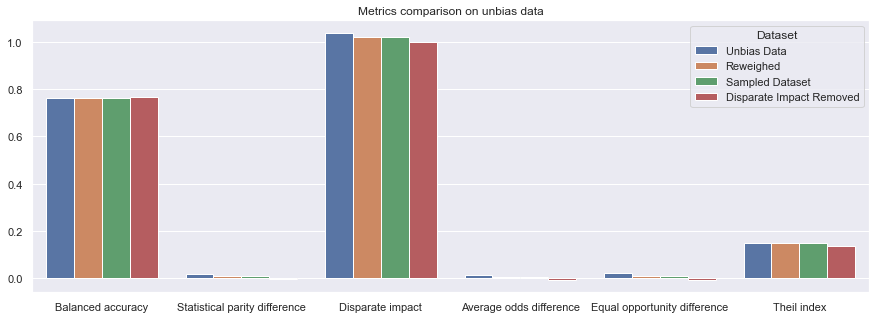

In [22]:
plot_syntesis(un_merged_metrics, 'Metrics comparison on unbias data')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [23]:
bias_data = data.copy()
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(len(data)/2)) , '10'] = 0.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


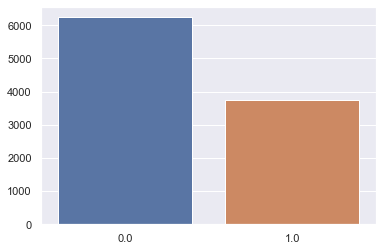

In [24]:
sns.barplot(x=bias_data['10'].value_counts().index, y=bias_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


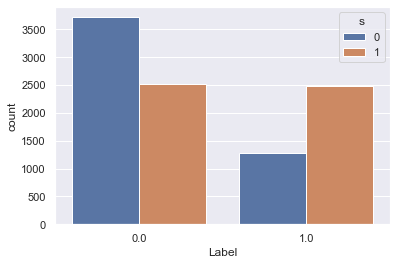

In [25]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

Let's compute the dataset fairness metrics on this new dataset:

In [26]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=['10'], protected_attribute_names=['s'])

### Dataset Metrics:

Disparate Impact: 0.5174
Statistical Parity: -0.2392




### Classification Metrics:

Balanced accuracy: 0.7262
Statistical parity difference: -0.3983
Disparate impact: 0.3984
Average odds difference: -0.3540
Equal opportunity difference: -0.5155
Theil index: 0.1496


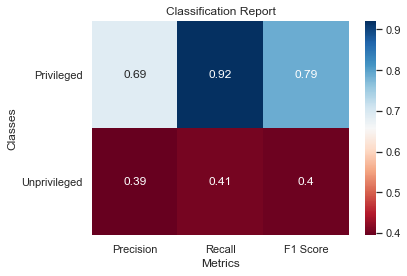

In [27]:
bias_class_metrics = classify(
    make_pipeline(StandardScaler(), 
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  bias_data_bin, privileged_group, unprivileged_group)

##  Reweighing

In [50]:
rw_data = bias_data_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
#rw_data = rw.fit_transform(rw_data)

In [51]:
#sns.violinplot(data=rw_data.instance_weights)
#plt.show()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7145
Statistical parity difference: -0.0673
Disparate impact: 0.8757
Average odds difference: 0.0089
Equal opportunity difference: -0.0911
Theil index: 0.1430


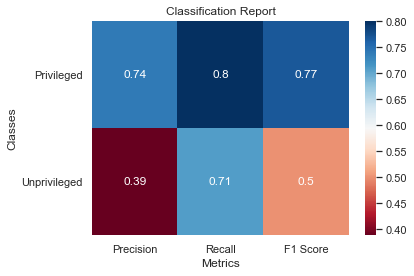

In [52]:
rw_class_metrics = classify(make_pipeline(StandardScaler(), 
                                          LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            rw_data, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


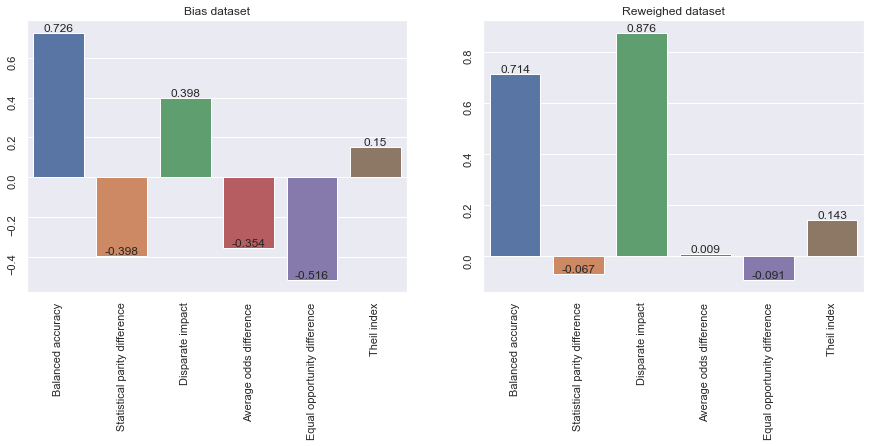

In [53]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [54]:
dir_data = bias_data_bin.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


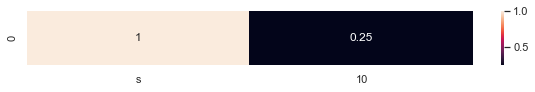

In [55]:
plot_correlation(dir_data, 's')
plt.show()

In [36]:
dr = DisparateImpactRemover(sensitive_attribute='s')
#dir_data = dr.fit_transform(dir_data)

### Dataset Metrics:

Disparate Impact: 0.5174
Statistical Parity: -0.2392




### Classification Metrics:

Balanced accuracy: 0.7098
Statistical parity difference: -0.0019
Disparate impact: 0.9991
Average odds difference: 0.0820
Equal opportunity difference: 0.0020
Theil index: 0.1363


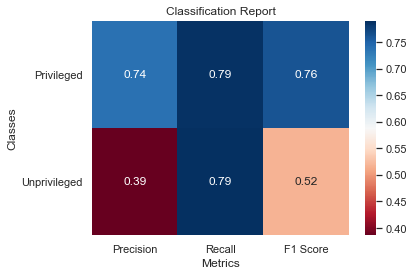

In [56]:
dir_class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced',solver='liblinear')), 
    dir_data, privileged_group, unprivileged_group,sensitive_attributes=['s'], debiaser=dr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


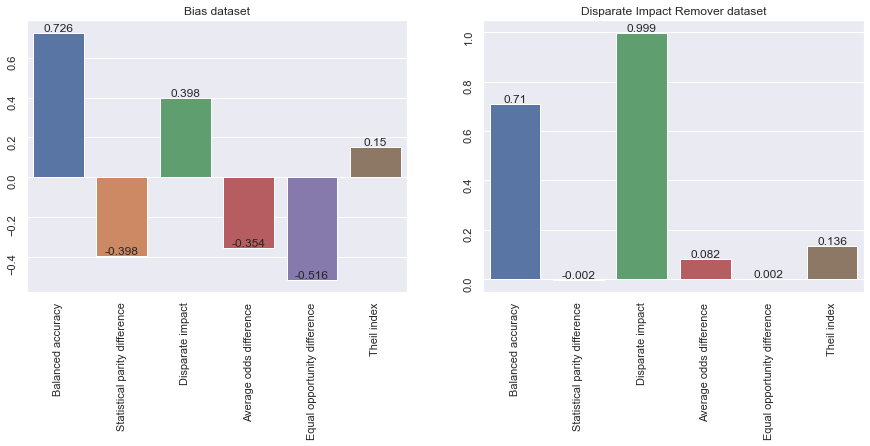

In [57]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plt.show()

## Modified Reweighing (Sampling)

In [58]:
sampled_bias_data = bias_data_bin.copy()
sampler = Sampler(round_level=3)

### Dataset Metrics:

Disparate Impact: 0.9994
Statistical Parity: -0.0002




### Classification Metrics:

Balanced accuracy: 0.7136
Statistical parity difference: -0.0669
Disparate impact: 0.8771
Average odds difference: 0.0094
Equal opportunity difference: -0.0898
Theil index: 0.1440


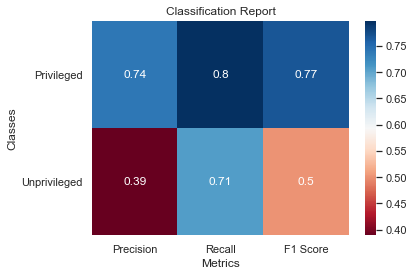

In [59]:
sample_bias_metrics = classify(make_pipeline(StandardScaler(), 
                                             LogisticRegression(class_weight='balanced', solver='liblinear')), 
                               sampled_bias_data, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


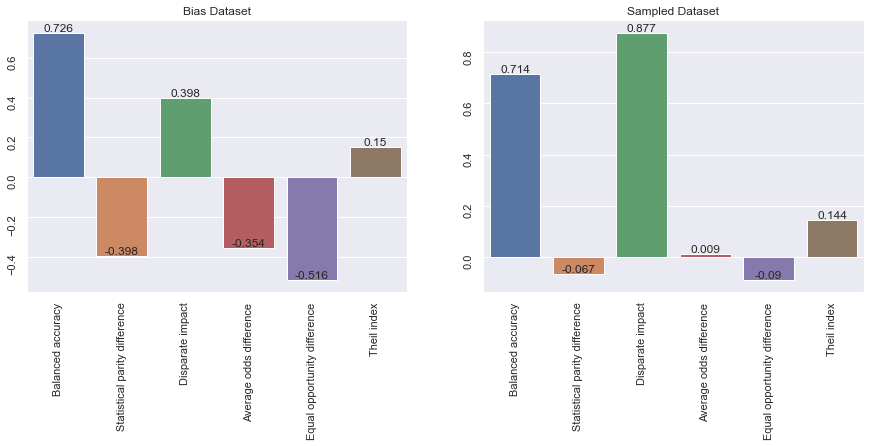

In [60]:
plot_metrics_comparison(bias_class_metrics, sample_bias_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [61]:
unbal_merged_metrics = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Sampled Dataset': sample_bias_metrics,
    'Disparate Impact Removed': dir_class_metrics
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3540,0.7262,0.3984,-0.5155,-0.3983,0.1496
Disparate Impact Removed,0.0820,0.7098,0.9991,0.0020,-0.0019,0.1363
Reweighed,0.0089,0.7145,0.8757,-0.0911,-0.0673,0.1430
Sampled Dataset,0.0094,0.7136,0.8771,-0.0898,-0.0669,0.1440


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


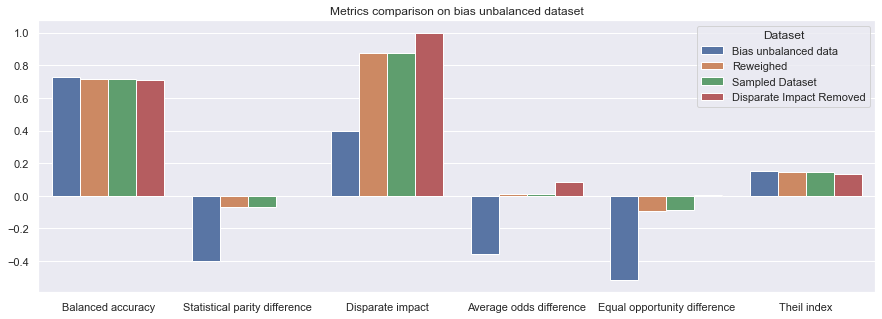

In [62]:
plot_syntesis(unbal_merged_metrics, 'Metrics comparison on bias unbalanced dataset')
plt.show()

# Bias balanced dataset

Let's balance the previous dataset changing the labels of half of the samples with `s=1` to `1.0`

In [68]:
bias_bal_data = bias_data.copy()
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(len(data)/2)) & (bias_data['10']==0.0) , '10'] = 1.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


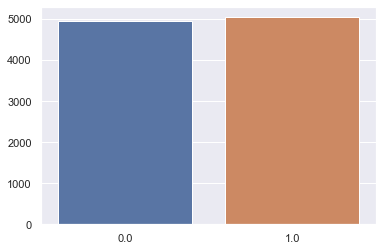

In [69]:
sns.barplot(x=bias_bal_data['10'].value_counts().index, y=bias_bal_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


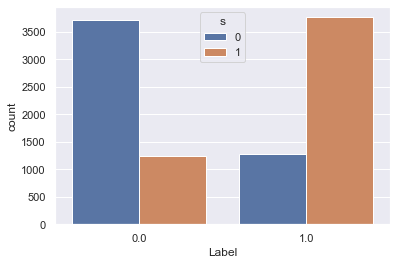

In [70]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

In [71]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=['10'], protected_attribute_names=['s'])

### Dataset Metrics:

Disparate Impact: 0.3406
Statistical Parity: -0.4964




### Classification Metrics:

Balanced accuracy: 0.7416
Statistical parity difference: -0.8857
Disparate impact: 0.0429
Average odds difference: -0.8559
Equal opportunity difference: -0.8893
Theil index: 0.1899


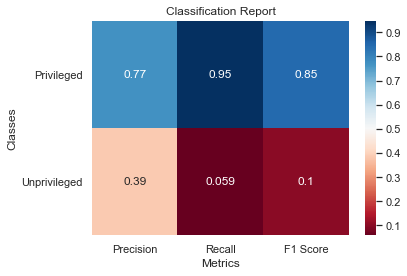

In [72]:
bias_bal_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    bias_bal_bin, privileged_group, unprivileged_group)

## Reweighing

In [75]:
rw_bal = bias_bal_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.6620
Statistical parity difference: -0.1375
Disparate impact: 0.7758
Average odds difference: 0.0316
Equal opportunity difference: 0.0255
Theil index: 0.2143


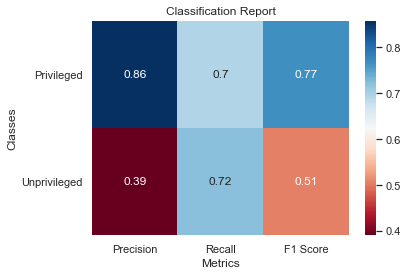

In [76]:
rw_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_bal, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


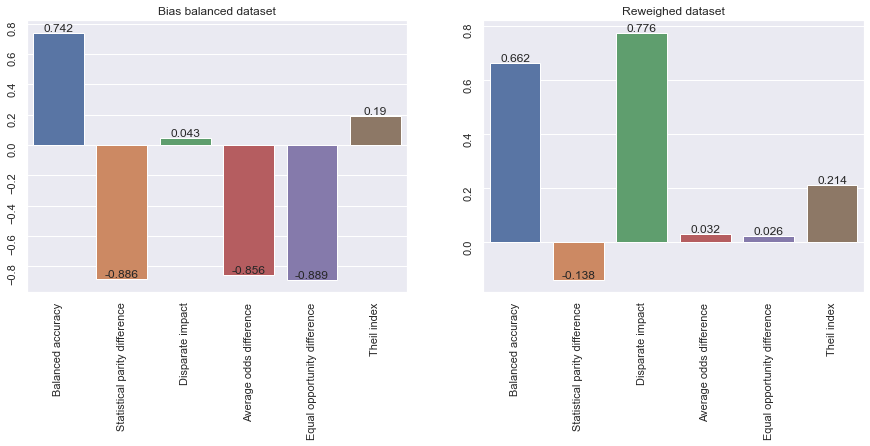

In [77]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Modified Reweighing (Sampling)

In [79]:
bias_sample_ds = bias_bal_bin.copy()
sampler = Sampler(round_level=3)

### Dataset Metrics:

Disparate Impact: 0.9993
Statistical Parity: -0.0004




### Classification Metrics:

Balanced accuracy: 0.6619
Statistical parity difference: -0.1372
Disparate impact: 0.7758
Average odds difference: 0.0326
Equal opportunity difference: 0.0252
Theil index: 0.2139


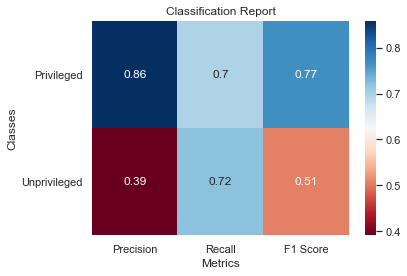

In [80]:
sampling_metrics = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            bias_sample_ds, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


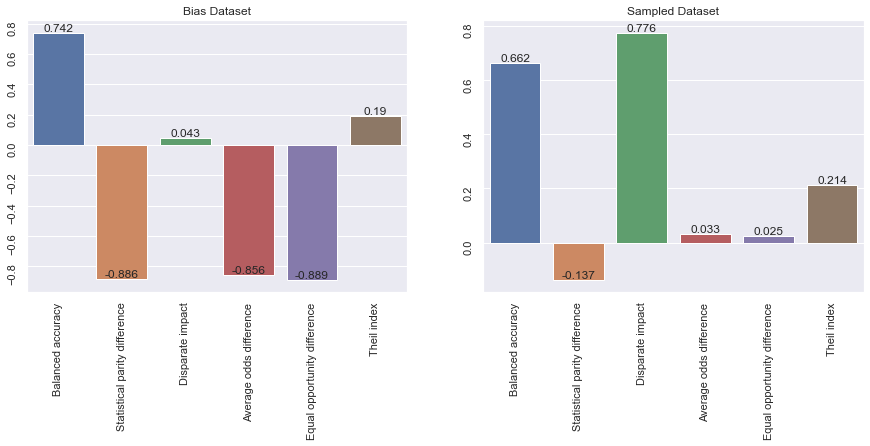

In [81]:
plot_metrics_comparison(bias_bal_metrics, sampling_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Disparate Impact Remover

In [82]:
dir_bal = bias_bal_bin.copy()
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


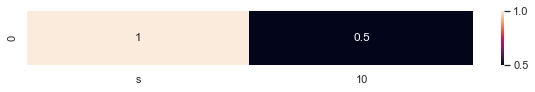

In [83]:
plot_correlation(dir_bal, 's')
plt.show()

In [84]:
dr = DisparateImpactRemover(sensitive_attribute='s')
#dir_bal = dr.fit_transform(dir_bal)

### Dataset Metrics:

Disparate Impact: 0.3406
Statistical Parity: -0.4964




### Classification Metrics:

Balanced accuracy: 0.6328
Statistical parity difference: -0.0008
Disparate impact: 0.9990
Average odds difference: 0.1749
Equal opportunity difference: 0.1795
Theil index: 0.2163


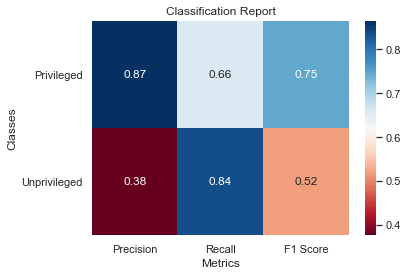

In [85]:
dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_bal, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=dr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


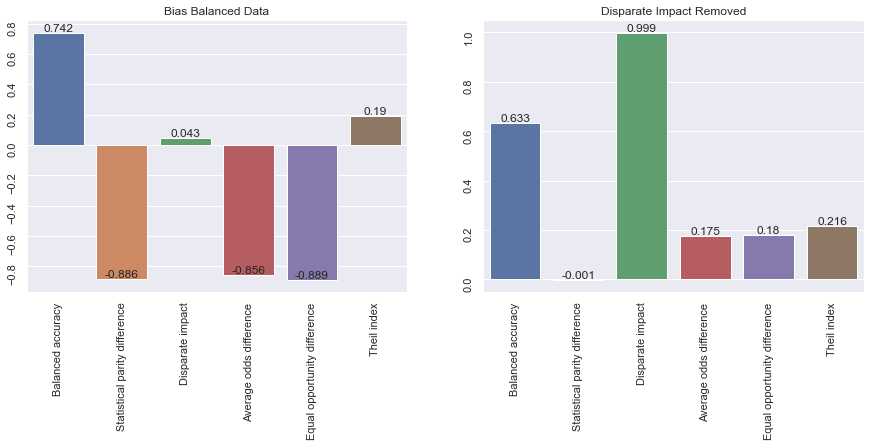

In [86]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [87]:
bal_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Sampled Dataset': sampling_metrics,
    'Disparate Impact Removed': dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8559,0.7416,0.0429,-0.8893,-0.8857,0.1899
Disparate Impact Removed,0.1749,0.6328,0.9990,0.1795,-0.0008,0.2163
Reweighed,0.0316,0.6620,0.7758,0.0255,-0.1375,0.2143
Sampled Dataset,0.0326,0.6619,0.7758,0.0252,-0.1372,0.2139


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


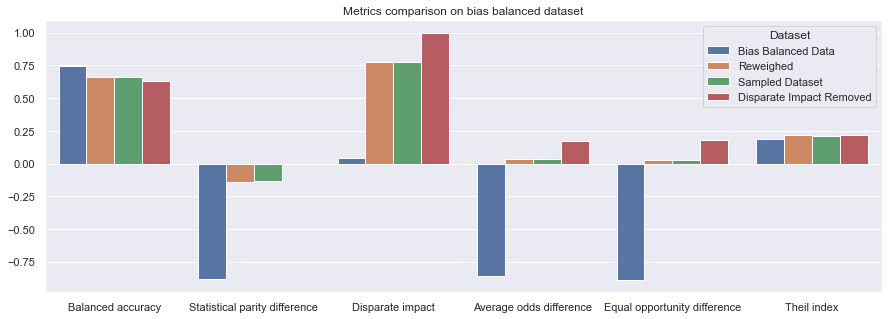

In [88]:
plot_syntesis(bal_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()

# Comparison of the three datasets

Here we compare the metrics for the three versions of the dataset and the methods applied:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


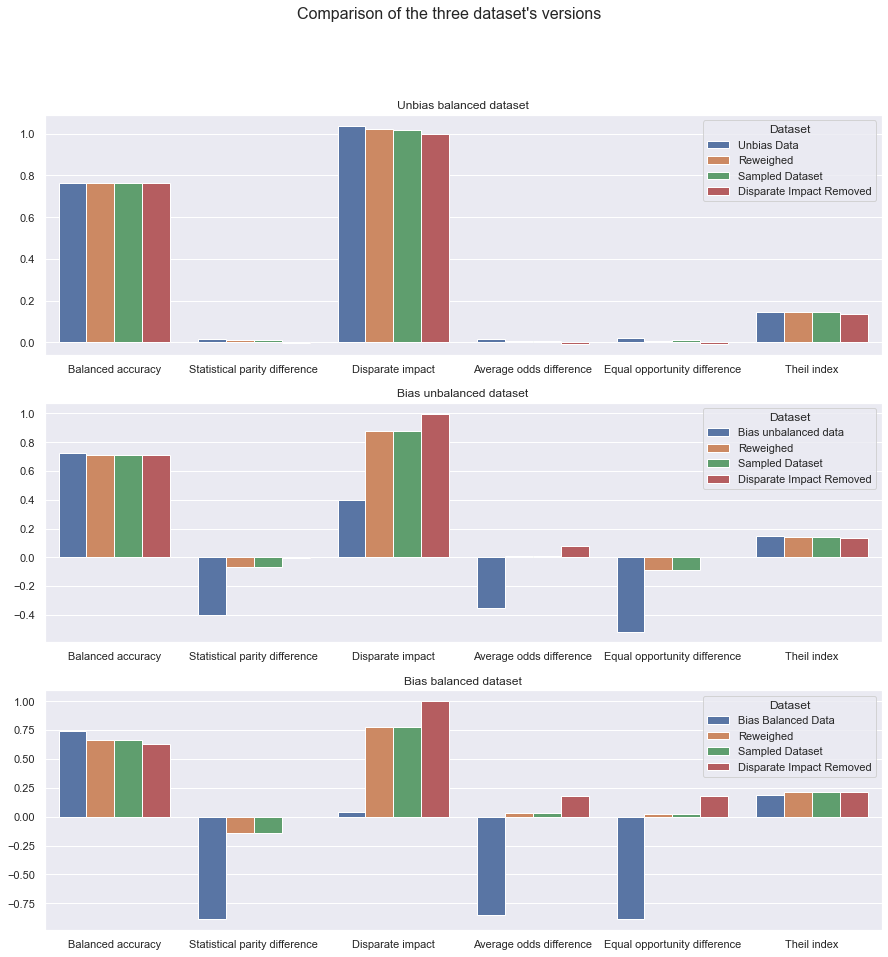

In [89]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=un_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[0],)
sns.barplot(data=unbal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[1])
sns.barplot(data=bal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[2])
for ax in axes:
    ax.set(xlabel='', ylabel='')
axes[0].set_title('Unbias balanced dataset')
axes[1].set_title('Bias unbalanced dataset')
axes[2].set_title('Bias balanced dataset')
fig.suptitle("Comparison of the three dataset's versions", fontsize=16)
plt.show()

# Combine Reweighing and DIR

As can be seen from the charts above both RW and DIR performs well in mitigating the unfairness of the classifier. However both have some lacks:

1. Reweighing requires that a classifier takes account of instance weights, but not all the classifier models do so
2. Disparate Impact Remover has no effect on the dataset fairness metrics but only on the classifier metrics

To solve these problems we will now try to combine these two algorithms by applying the instance weights to the DIR modified dataset and see the results.

## Test with unbias data

In [90]:
un_rw_dir = dir_unb_data.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
un_rw_dir = rw.fit_transform(un_rw_dir)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7626
Statistical parity difference: -0.0070
Disparate impact: 0.9874
Average odds difference: -0.0072
Equal opportunity difference: -0.0079
Theil index: 0.1481


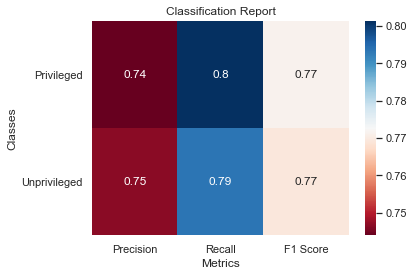

In [92]:
unb_rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            un_rw_dir, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [93]:
un_rw_dir_merg =  merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics,
    'RW + DIR': unb_rw_dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Disparate Impact Removed,-0.0062,0.7654,0.9996,-0.0052,-0.0011,0.1362
RW + DIR,-0.0072,0.7626,0.9874,-0.0079,-0.0070,0.1481
Reweighed,0.0055,0.7627,1.0219,0.0086,0.0102,0.1480
Unbias Data,0.0148,0.7623,1.0378,0.0210,0.0188,0.1482


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


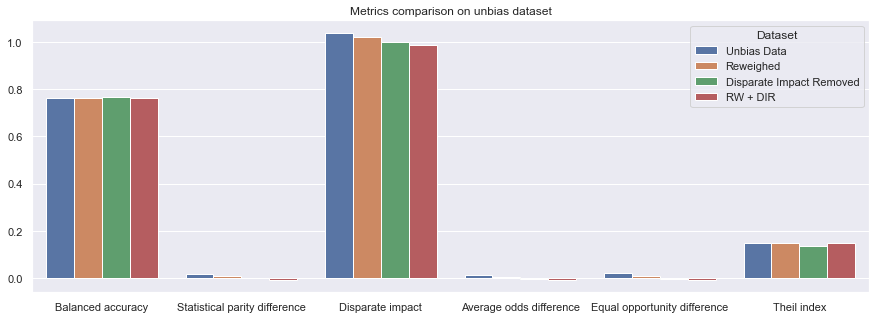

In [94]:
plot_syntesis(un_rw_dir_merg, 'Metrics comparison on unbias dataset')
plt.show()

## Test with unbalance bias data

In [95]:
unbal_dir_rw_data = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
unbal_dir_rw_data = rw.fit_transform(unbal_dir_rw_data)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7162
Statistical parity difference: 0.0998
Disparate impact: 1.2281
Average odds difference: 0.0812
Equal opportunity difference: 0.0041
Theil index: 0.1465


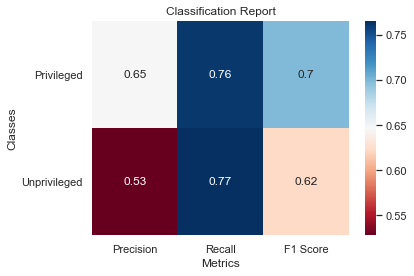

In [97]:
rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            unbal_dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [98]:
unbal_rw_dir_score = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics,
    'RW + DIR': rw_dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3549,0.7262,0.3971,-0.5165,-0.3988,0.1500
Disparate Impact Removed,0.0927,0.7057,1.0226,0.0118,0.0102,0.1502
RW + DIR,0.0909,0.7144,1.2526,0.0123,0.1108,0.1478
Reweighed,0.0107,0.7118,1.0769,-0.0895,0.0359,0.1437


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


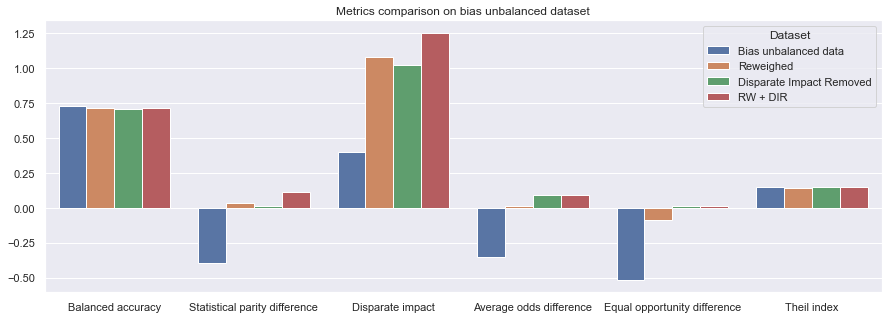

In [106]:
plot_syntesis(unbal_rw_dir_score, 'Metrics comparison on bias unbalanced dataset')
plt.show()

## Test with balanced bias data

In [107]:
dir_rw_data = dir_bal.copy()
rw = Reweighing(unprivileged_group, privileged_group)
dir_rw_data = rw.fit_transform(dir_rw_data)

In [108]:
score = compute_dataset_fairness_metrics(dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.6758
Statistical parity difference: 0.1835
Disparate impact: 1.4081
Average odds difference: 0.1836
Equal opportunity difference: 0.1940
Theil index: 0.2342


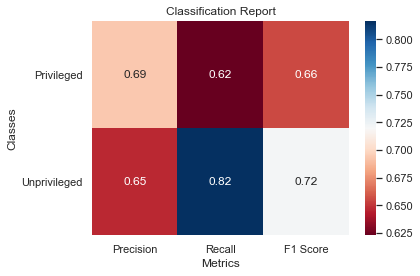

In [109]:
rw_dir_score = classify(make_pipeline(StandardScaler(),LogisticRegression(class_weight='balanced', solver='liblinear')),
                        dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [110]:
rw_dir_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score,
    'RW + DIR': rw_dir_score
})

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8575,0.7418,0.0418,-0.8924,-0.8868,0.1901
Disparate Impact Removed,0.1840,0.6309,1.0160,0.1861,0.0074,0.2320
RW + DIR,0.1836,0.6758,1.4081,0.1940,0.1835,0.2342
Reweighed,0.0307,0.6696,1.0578,0.0251,0.0295,0.2143


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


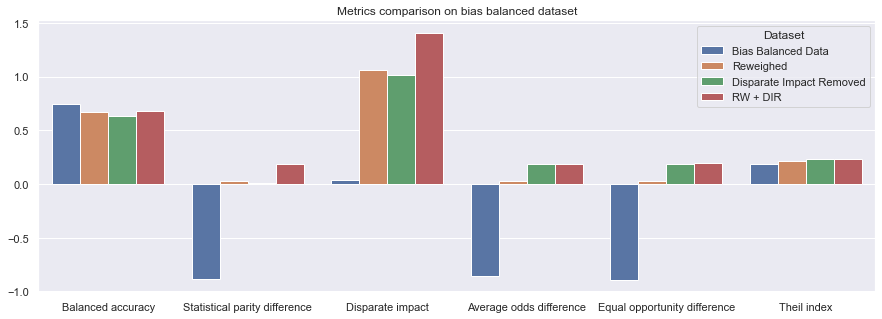

In [111]:
plot_syntesis(rw_dir_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()